## Ejercicio 3

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

### Introducción

En este ejercicio, se explora el uso de técnicas de NLP para analizar el primer libro de la serie "Game of Thrones". Se utilizan diferentes métodos de tokenización para procesar el texto y se comparan sus resultados para entender mejor cómo cada enfoque maneja los datos. Este análisis nos permite preparar el texto para modelar embeddings de palabras, lo que nos proporcionará una comprensión más profunda de las relaciones semánticas en el texto.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import os
import re

from keras.preprocessing.text import text_to_word_sequence

import nltk

# Descargar diccionario
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\karen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Datos

Cargamos el dataset que se encuentra en un archivo de texto, y lo leemos como un DataFrame de pandas.

In [60]:
df = pd.read_csv('./GOT/001ssb.txt', sep='/n', header=None, encoding='latin-1')
df.head()

C:\Users\karen\AppData\Local\Temp\ipykernel_8644\3002682383.py:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



,0
0,A Game Of Thrones
1,Book One of A Song of Ice and Fire
2,By George R. R. Martin
3,PROLOGUE
4,"""We should start back,"" Gared urged as the woo..."


In [61]:
# Cantidad de filas en los datos
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 19598


Se usa la función text_to_word_sequence de Keras para tokenizar el texto del libro. Esta función nos proporciona una forma sencilla de dividir el texto en palabras individuales.

In [47]:
sentence_tokens = []

# Transformar las oraciones en una secuencia de palabras 
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

# Ver los primeros 5 elementos
sentence_tokens[:5]

[['a', 'game', 'of', 'thrones'],
 ['book', 'one', 'of', 'a', 'song', 'of', 'ice', 'and', 'fire'],
 ['by', 'george', 'r', 'r', 'martin'],
 ['prologue'],
 ['we',
  'should',
  'start',
  'back',
  'gared',
  'urged',
  'as',
  'the',
  'woods',
  'began',
  'to',
  'grow',
  'dark',
  'around',
  'them',
  'the',
  'wildlings',
  'are']]

In [62]:
print("Número de tokens generados por el primer método: ", len(sentence_tokens))

Número de tokens generados por el primer método:  19598


A continuación, se aplica un enfoque más detallado para la tokenización, utilizando NLTK junto con expresiones regulares. Esto nos permite limpiar el texto de caracteres no deseados y realizar una tokenización más precisa.

In [55]:
sentence_tokens_NLTK = []
pattern = r'[^a-zA-z0-9/\'\"s]'

for _, row in df.iterrows():  
    words = re.sub(pattern, ' ', row[0])  # Reemplazar caracteres no deseados con espacios
    words = re.sub(r'[_]', ' ', words)  # Reemplazar guiones bajos con espacios
    words = words.lower()  # Convertir el texto a minúsculas para estandarizar
    sentence_tokens_NLTK.append(nltk.word_tokenize(words))  # Tokenizar el texto y agregar a la lista

# Ver los primeros 5 elementos
print(sentence_tokens_NLTK[:5])

[['a', 'game', 'of', 'thrones'], ['book', 'one', 'of', 'a', 'song', 'of', 'ice', 'and', 'fire'], ['by', 'george', 'r', 'r', 'martin'], ['prologue'], ['``', 'we', 'should', 'start', 'back', '``', 'gared', 'urged', 'as', 'the', 'woods', 'began', 'to', 'grow', 'dark', 'around', 'them', '``', 'the', 'wildlings', 'are']]


In [63]:
print("Número de tokens generados por el método NLTK: ", len(sentence_tokens_NLTK))

Número de tokens generados por el método NLTK:  19598


Comparamos los tokens generados por los dos métodos anteriores. Este análisis nos permite identificar discrepancias y comprender cómo cada enfoque procesa el texto de manera diferente.

In [58]:
# Verificar las diferencias en el procesamiento de las palabras 
dif_words = [] 
q_dif_words = 0  

# Iterar sobre los tokens generados por ambos métodos
for i, j in zip(sentence_tokens, sentence_tokens_NLTK):
    if i != j:
        # Si los tokens de la misma posición son diferentes, compara palabra por palabra
        for l, k in zip(i, j):
            if l != k:
                dif_words.append([l, k])  # Añadir el par de palabras diferentes a la lista
                q_dif_words += 1  # Incrementar el contador de diferencias

            # Si se encontraron más de 10 diferencias, salir del bucle interno
            if q_dif_words > 10:
                break

    # Si se encontraron más de 10 diferencias, salir del bucle externo
    if q_dif_words > 10:
        break    

# Imprimir la cantidad total de pares de palabras diferentes encontradas
print("Total de diferencias encontradas:", len(dif_words))

Total de diferencias encontradas: 11


In [64]:
dif_words

[['we', '``'],
 ['should', 'we'],
 ['start', 'should'],
 ['back', 'start'],
 ['gared', 'back'],
 ['urged', '``'],
 ['as', 'gared'],
 ['the', 'urged'],
 ['woods', 'as'],
 ['began', 'the'],
 ['to', 'woods']]

Analizando los pares de palabras en dif_words, parece que hay una diferencia significativa en cómo cada método de tokenización está manejando el texto. Por ejemplo:

* En varios casos, una palabra en el primer token corresponde a la palabra siguiente en el segundo token, como en ['we', '``'], ['should', 'we'], ['start', 'should']. Esto sugiere que uno de los métodos de tokenización está desfasado en una palabra respecto al otro.

* Las diferencias en la tokenización pueden deberse a cómo cada método trata los caracteres especiales, las comillas, y la puntuación. Por ejemplo, el par ['we', '``'] sugiere que un método está capturando las comillas dobles como un token separado, mientras que el otro no.

### Word2Vec con Gensim

Construimos y entrenamos un modelo Word2Vec utilizando la biblioteca Gensim. Word2Vec es un grupo de modelos relacionados que se utilizan para producir word embeddings, es decir, representaciones vectoriales de palabras. Estos modelos son redes neuronales de dos capas entrenadas para reconstruir contextos lingüísticos de palabras.

In [68]:
# Definición de la clase callback para monitorear la pérdida durante el entrenamiento
class callback(CallbackAny2Vec):
    """
    Clase callback para imprimir la pérdida ('loss') después de cada época de entrenamiento.
    Esta clase se utiliza para obtener información detallada sobre el proceso de aprendizaje
    del modelo y ajustar parámetros si es necesario.
    """
    def __init__(self):
        self.epoch = 0  # Inicializa el contador de épocas
        self.loss_previous_step = 0  # Inicializa la pérdida en el paso anterior

    def on_epoch_end(self, model):
        # Método llamado al final de cada época
        loss = model.get_latest_training_loss()  # Obtiene la pérdida más reciente del modelo
        if self.epoch == 0:
            print(f'Loss after epoch {self.epoch}: {loss}')
        else:
            # Calcula la pérdida desde la última época
            print(f'Loss after epoch {self.epoch}: {loss - self.loss_previous_step}')
        self.epoch += 1  # Incrementa el contador de épocas
        self.loss_previous_step = loss  # Actualiza la pérdida anterior para la próxima comparación

Para nuestro modelo, elegimos la estructura Skipgram de Word2Vec. A diferencia del modelo CBOW (Continuous Bag of Words), Skipgram predice las palabras de contexto a partir de una palabra objetivo, lo que suele ser más efectivo para conjuntos de datos más grandes y con palabras menos frecuentes.

In [69]:
# Creación del modelo Word2Vec utilizando la estructura de modelo Skipgram
w2v_model = Word2Vec(
    min_count=5,    # Frecuencia mínima de palabra para ser incluida en el vocabulario
    window=2,       # Cantidad de palabras antes y después de la palabra objetivo para considerar en el contexto
    vector_size=300, # Dimensionalidad de los vectores de palabras
    negative=20,    # Cantidad de "negative samples" (muestra de palabras no relacionadas); 0 significa que no se usa
    workers=1,      # Cantidad de hilos de procesamiento para entrenar el modelo (ajustar según la máquina)
    sg=1)            # Define el algoritmo de entrenamiento: 0 para CBOW, 1 para Skipgram

In [70]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)
#w2v_model.build_vocab(sentence_tokens_NLTK)

In [71]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 19598


In [72]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 4271


Entrenar embeddings

In [73]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=30,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 2333840.75
Loss after epoch 1: 1640345.25
Loss after epoch 2: 1536630.0
Loss after epoch 3: 1507944.5
Loss after epoch 4: 1484651.5
Loss after epoch 5: 1419345.0
Loss after epoch 6: 1402366.0
Loss after epoch 7: 1384269.0
Loss after epoch 8: 1368241.0
Loss after epoch 9: 1355779.0
Loss after epoch 10: 1342403.0
Loss after epoch 11: 1284843.0
Loss after epoch 12: 1273010.0
Loss after epoch 13: 1257160.0
Loss after epoch 14: 1247398.0
Loss after epoch 15: 1234776.0
Loss after epoch 16: 1221948.0
Loss after epoch 17: 1213638.0
Loss after epoch 18: 1205520.0
Loss after epoch 19: 1194448.0
Loss after epoch 20: 1184344.0
Loss after epoch 21: 1177638.0
Loss after epoch 22: 1170482.0
Loss after epoch 23: 1166128.0
Loss after epoch 24: 1152328.0
Loss after epoch 25: 1126688.0
Loss after epoch 26: 1114760.0
Loss after epoch 27: 1116904.0
Loss after epoch 28: 1109456.0
Loss after epoch 29: 1101404.0


(6179997, 8833650)

Ensayar

In [74]:
w2v_model.wv.index_to_key[100:120]

['dany',
 'sansa',
 'then',
 'stark',
 'yet',
 'robb',
 'head',
 'too',
 'away',
 'made',
 'where',
 'through',
 'how',
 'lady',
 'robert',
 'took',
 'come',
 'thought',
 'sword',
 'must']

In [75]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["sansa"], topn=10)

[('jeyne', 0.3923870623111725),
 ('arya', 0.373152494430542),
 ('shave', 0.3679894506931305),
 ('blinking', 0.3674989938735962),
 ('chewing', 0.36326882243156433),
 ('whimpered', 0.3568113446235657),
 ('torrhen', 0.3554721772670746),
 ('mordane', 0.3525380790233612),
 ("sansa's", 0.3509036600589752),
 ('miserably', 0.35044562816619873)]

In [76]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["sansa"], topn=10)

[('earth', 0.02474198490381241),
 ('remain', 0.012754547409713268),
 ('hundred', 0.008418884128332138),
 ('cell', 0.008270381018519402),
 ('battle', 0.007254032883793116),
 ('urged', 0.0029458212666213512),
 ('led', 0.0016865921206772327),
 ('spread', -0.0003114058345090598),
 ('spotted', -0.0021455748938024044),
 ('remained', -0.012433255091309547)]

In [77]:
# el método `get_vector` permite obtener los vectores:
vector_ring = w2v_model.wv.get_vector("ring")
print(vector_ring)

[-2.73328960e-01  2.65352190e-01  1.15855537e-01 -2.82472204e-02
  8.91635418e-02 -6.19090982e-02 -7.83740729e-02  2.04023600e-01
 -5.78460097e-02 -4.48846281e-01  3.20527673e-01 -2.70255823e-02
 -2.71470577e-01  9.29924287e-03  1.50349233e-02 -2.81877607e-01
  9.16409045e-02  9.03073549e-02  1.28863990e-01  1.20107353e-01
  9.40671563e-02  2.07038790e-01 -1.97467968e-01 -1.47694394e-01
  6.79049492e-01 -2.14309305e-01  1.20615013e-01  9.59969535e-02
 -4.09818798e-01  1.18843868e-01  8.57853368e-02 -2.83157565e-02
  1.47599310e-01  3.26120526e-01  2.96091698e-02 -5.19577339e-02
  2.37894937e-01 -2.13020965e-01  5.33839092e-02 -5.53691015e-02
 -2.03870744e-01 -1.40628576e-01  2.36041948e-01 -6.72216490e-02
  1.47836983e-01  5.35787903e-02 -1.46687567e-01  7.22649470e-02
 -3.58034909e-01  2.44407445e-01  1.80935010e-01 -2.25633949e-01
 -2.24750116e-01  4.86307383e-01 -4.46492851e-01  1.21609561e-01
  2.60825418e-02 -1.93176836e-01  4.89647277e-02  4.06266451e-02
  1.10695697e-01  3.65469

In [78]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_ring)

[('ring', 1.0),
 ('clangor', 0.6129792928695679),
 ('swordplay', 0.581631064414978),
 ('spell', 0.5815053582191467),
 ('banded', 0.5746070146560669),
 ('parchment', 0.5742110013961792),
 ('clang', 0.5594696402549744),
 ('clack', 0.5588715672492981),
 ('lobstered', 0.5529549717903137),
 ('bark', 0.5485979914665222)]

In [79]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["ring"], topn=10)

[('clangor', 0.6129792928695679),
 ('swordplay', 0.5816310048103333),
 ('spell', 0.5815053582191467),
 ('banded', 0.5746070742607117),
 ('parchment', 0.5742110013961792),
 ('clang', 0.5594696402549744),
 ('clack', 0.5588715672492981),
 ('lobstered', 0.5529549717903137),
 ('bark', 0.5485979914665222),
 ('tipped', 0.5396092534065247)]

Visualizar agrupación de vectores

In [80]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [81]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=100
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig
#fig.show(renderer="colab") # esto para plotly en colab

In [82]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/

vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("./vectors.tsv", vectors, delimiter="\t")

with open("./labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

In [83]:
# Armamos una función para graficar la matriz de similaridad
def plot_matrix_distance(words, dist):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words, 
                annot=True, fmt=".2f", cmap="YlGnBu", ax=ax, mask=np.triu(dist))
    plt.show()

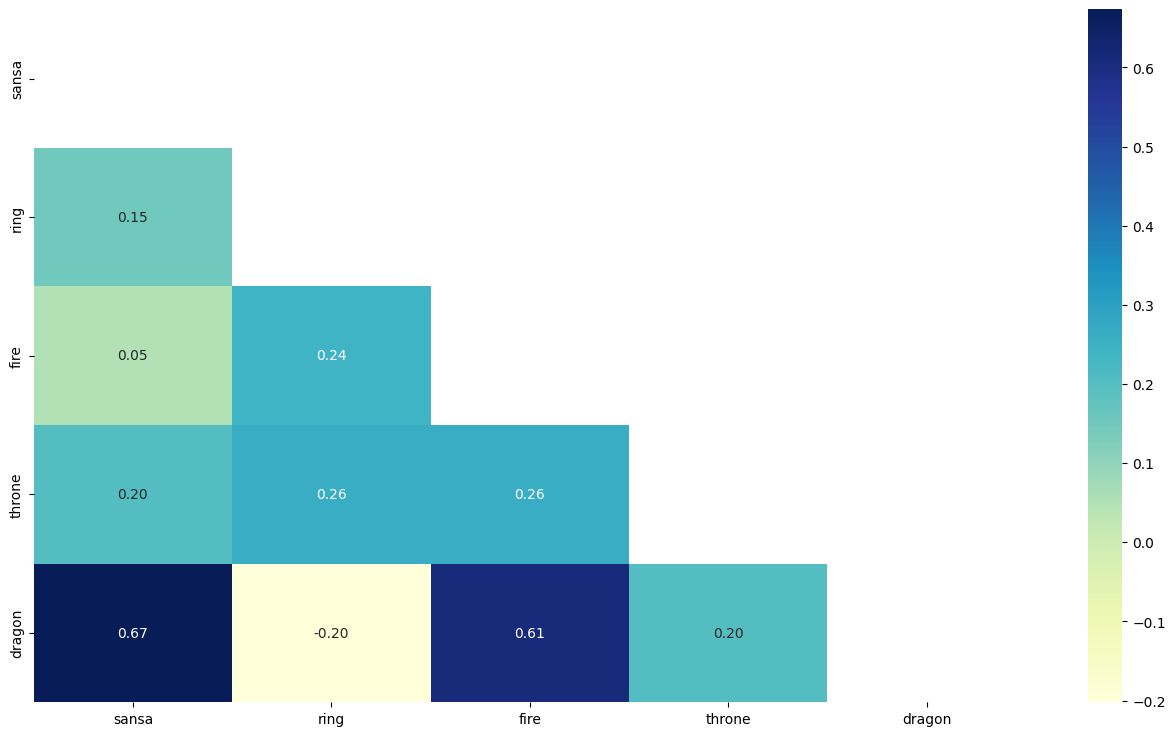

In [88]:
from sklearn.metrics import pairwise
# probamos un test de analogía
test_words = ['sansa', 'ring', 'fire', 'throne']

test_emb = []
for word in test_words:
    test_emb.append(w2v_model.wv.get_vector(word))
    
# legolas - elves + frodo
new_hobbit = test_emb[0] - test_emb[1] + test_emb[2]

new_words = test_words + ['dragon']
new_emb = np.append(test_emb, new_hobbit.reshape(1, -1), axis=0)

dist = pairwise.cosine_similarity(new_emb, new_emb)

plot_matrix_distance(new_words, dist)

In [89]:
# calculamos la similaridad de 'new_hobbit' contra todos los vectores
# puede tardar unos segundos
similarities = np.squeeze(pairwise.cosine_similarity(w2v_model.wv.vectors,np.array([new_hobbit])))

In [90]:
# vemos cuáles son los 10 vectores más similares
args_sorted = np.argsort(similarities)[::-1][:10]
for arg in args_sorted:
  print(f'{labels[arg]}: {similarities[arg]}')

sansa: 0.6733781099319458
fire: 0.6117540001869202
wouldn't: 0.3649292290210724
shuddered: 0.3395819664001465
lyanna: 0.33492380380630493
': 0.32705873250961304
blinking: 0.32105347514152527
miserably: 0.32021862268447876
animals: 0.3186982572078705
mordane: 0.31674614548683167
